In [28]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
import numpy as np
from sklearn.preprocessing import RobustScaler
from sklearn.cluster import DBSCAN
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA

In [2]:
data = pd.read_csv('cleaned_dataset.csv')

In [4]:
data.head(1)

,bet_id,user_id,bet_type,sport,is_win,odds_log,stake_log,gain_log,GGR_log
0,bet_00001,3848,multiple,Ice Hockey,False,2.345645,2.68444,0.0,6.894974


In [5]:
# Random Forest fo predict is_win
features = ['bet_type', 'sport', 'odds_log', 'stake_log', 'gain_log', 'GGR_log']
X = data[features]
y = data['is_win']

In [6]:
# One-Hot Encoding for categorical variables
X_encoded = pd.get_dummies(X, columns=['bet_type', 'sport'])

In [8]:
# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.3, random_state=42)

# Train model
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Predict and evaluate
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:,1]

print(classification_report(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_prob))

              precision    recall  f1-score   support

       False       1.00      1.00      1.00     19110
        True       1.00      1.00      1.00     10890

    accuracy                           1.00     30000
   macro avg       1.00      1.00      1.00     30000
weighted avg       1.00      1.00      1.00     30000

ROC-AUC: 1.0


In [ ]:
# This situation whena all metrics are 100% is very rare, so it may be indicate overfitting.
# Have in mind that gain_log and GGR_gain are directly delivered from is_win let's make model without them. 

In [9]:
# Use only features available before the bet outcome is known
features = ['sport', 'bet_type', 'odds_log', 'stake_log']  # exclude gain_log, GGR_log
X = data[features]
y = data['is_win']

# Encode categoricals
X_encoded = pd.get_dummies(X, columns=['bet_type', 'sport'])

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

# Train model
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Evaluate
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

from sklearn.metrics import classification_report, roc_auc_score
print(classification_report(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_prob))

              precision    recall  f1-score   support

       False       0.74      0.80      0.77     12714
        True       0.60      0.51      0.55      7286

    accuracy                           0.70     20000
   macro avg       0.67      0.66      0.66     20000
weighted avg       0.69      0.70      0.69     20000

ROC-AUC: 0.7283181760810511


In [ ]:
# accuracy 70%, 7 of 10 are cerrectly predicted. precision(TRUE class) 60%-actually won. recall 51% captures actually wins.
# f-1 score 55%, balance between precision and recall. There will be improve with GridSearchCV.
# ROC-AUC-72.8% model ability to separate wins from loses.

In [11]:
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [5, 10, None],
    'min_samples_split': [2, 5],
}

grid = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=3, scoring='roc_auc')
grid.fit(X_train, y_train)

print("Best params:", grid.best_params_)
print("Best ROC-AUC on CV:", grid.best_score_)

Best params: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 200}
Best ROC-AUC on CV: 0.787330438562864


In [12]:
final_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    min_samples_split=2,
    random_state=42
)

# Fit to training data
final_model.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, n_estimators=200, random_state=42)

In [13]:
# Predictions
y_pred = final_model.predict(X_test)
y_prob = final_model.predict_proba(X_test)[:, 1]

# Evaluation metrics
print(classification_report(y_test, y_pred))
print("Test ROC-AUC:", roc_auc_score(y_test, y_prob))

              precision    recall  f1-score   support

       False       0.79      0.83      0.81     12714
        True       0.67      0.62      0.65      7286

    accuracy                           0.75     20000
   macro avg       0.73      0.72      0.73     20000
weighted avg       0.75      0.75      0.75     20000

Test ROC-AUC: 0.7916924346864361


In [ ]:
# All metrics are better now, especially f1-score 65%, more balance for win prediction.

In [15]:
xgb_model = XGBClassifier(
    n_estimators=200,
    max_depth=10,
    learning_rate=0.1,
    random_state=42
)

xgb_model.fit(X_train, y_train)
y_pred = xgb_model.predict(X_test)
y_prob = xgb_model.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred))
print("XGBoost ROC-AUC:", roc_auc_score(y_test, y_prob))

              precision    recall  f1-score   support

       False       0.79      0.82      0.80     12714
        True       0.66      0.61      0.64      7286

    accuracy                           0.75     20000
   macro avg       0.73      0.72      0.72     20000
weighted avg       0.74      0.75      0.74     20000

XGBoost ROC-AUC: 0.7820809471197054


In [ ]:
# Random forest is still best, pefrormanse are very similar.

In [ ]:
# have inmind that data are not normaly distributed, and skewed, DBSCAN will below

In [ ]:
# aggregate data to user level

user_df = data.groupby("user_id").agg({
    "stake_log": "sum",
    "odds_log": "mean",
    "is_win": "mean",  # win rate
    "bet_id": "count",  # total bets
    "gain_log": "sum",
    "GGR_log": "sum"
}).reset_index()

user_df.rename(columns={
    "stake_log": "total_stake",
    "odds_log": "avg_odds",
    "is_win": "win_rate",
    "bet_id": "total_bets",
    "gain_log": "total_gain",
    "GGR_log": "total_GGR"
}, inplace=True)

In [ ]:
# feature scale
features = ['total_stake', 'avg_odds', 'win_rate', 'total_bets', 'total_gain', 'total_GGR']
X = user_df[features]

scaler = RobustScaler()
X_scaled = scaler.fit_transform(X)

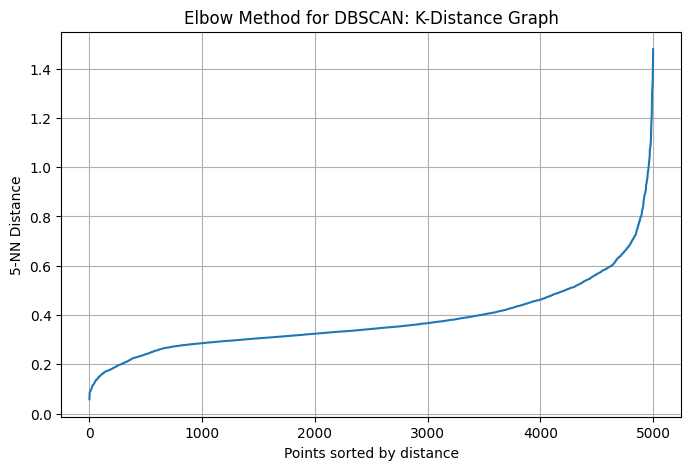

In [26]:
# elbow method to find eps
neighbors = NearestNeighbors(n_neighbors=5)
neighbors_fit = neighbors.fit(X_scaled)
distances, indices = neighbors_fit.kneighbors(X_scaled)

# Sort distances
distances = np.sort(distances[:, 4])  # 4 = min_samples-1
plt.figure(figsize=(8, 5))
plt.plot(distances)
plt.title("Elbow Method for DBSCAN: K-Distance Graph")
plt.xlabel("Points sorted by distance")
plt.ylabel("5-NN Distance")
plt.grid()
plt.show()


In [ ]:
# it seems that eps=0.7

In [36]:
db = DBSCAN(eps=0.7, min_samples=5)
labels = db.fit_predict(X_scaled)

user_df['cluster'] = labels

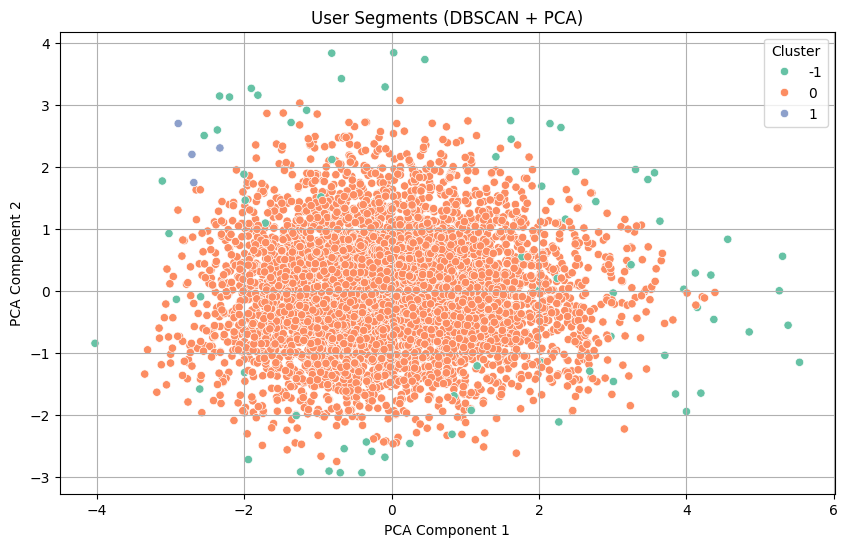

In [37]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=user_df['cluster'], palette='Set2')
plt.title("User Segments (DBSCAN + PCA)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title="Cluster")
plt.grid()
plt.show()

In [38]:
user_df.groupby('cluster')[features].mean()

,total_stake,avg_odds,win_rate,total_bets,total_gain,total_GGR
cluster,,,,,,
-1,97.427239,1.452203,0.432520,22.614458,47.107556,154.122212
0,83.864669,1.507717,0.363168,19.964584,34.897796,136.670852
1,17.455269,1.293711,0.570139,9.250000,12.103313,63.900579


In [ ]:
#there are tree clusters: -1 (green) represent outliers, users with very few bets;
#                          0 (orange) majoriti of users in centar cluster, very similar behaviour across scaled features
#                          1 (blue) small unique group, posibly high win rate or low risk.